# Entrenamiento RN

In [2]:
import pandas as pd
import numpy as np

import missingno as msno
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split 
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
import datetime
from dateutil.parser import parse
from sklearn.tree import  DecisionTreeClassifier
import plotly.graph_objects as go
import umap
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
import xgboost as xgb
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
import ml_metrics
import pickle
from sklearn.metrics import accuracy_score
import joblib
import json
import sklearn.metrics as metrics
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD, Adam
from keras.callbacks import TensorBoard
from keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings("ignore")

In [3]:
Data=pd.read_csv("cleaned_01June2022.csv").drop(columns=["Unnamed: 0"]).fillna("")

In [4]:
# datos númericos
numerical=list(Data.select_dtypes(exclude=["category","object"]).columns)
numerical.remove("Sexo")
numerical.remove('Recibe_sueldo_en_cuenta')


# datos categorical
categorical=list(Data.select_dtypes(include=["category","object"]).columns)+['Sexo','Recibe_sueldo_en_cuenta']
categorical.remove("Target")

In [5]:
for i in categorical:
    Data[i]=Data[i].astype(str)

In [6]:
# Select 1 - Only Gini, corte visual
select_variables_1=['E-F',
 'C-C',
 'D-F',
 'A-K',
 'num_comunicaciones',
 'Length',
 'pref_A-A',
 'Positivo',
 'Recency',
 'A-G',
 'Monto',
 'Periodicity',
 'Frequency',
 'lec_B-B',
 'G-K']

In [7]:
numerical1=list(filter(lambda x:x  in numerical,select_variables_1))
categorical1=list(filter(lambda x:x  in categorical,select_variables_1))

In [8]:
# Preprocesamiento de datos
preprocessing_transformer1 = ColumnTransformer(
    transformers=[('OneHotEncoder', OneHotEncoder(handle_unknown="ignore"),categorical1 ),
        ('MinMax', MinMaxScaler(),numerical1),
    ])

In [9]:
pipe1 = Pipeline(
    [("preprocesamiento", preprocessing_transformer1)]
)

------------------------

# Train, Test Split

In [10]:
X=Data.drop(columns=["Target"])[select_variables_1].copy()

In [11]:
Y=Data["Target"]

In [12]:
enc = OneHotEncoder()
Y = enc.fit_transform(Y[:, np.newaxis]).toarray()

In [13]:
dic={}
to_enc_inv=list(enc.categories_[0])
for i in range(len(to_enc_inv)):
    dic[i]=to_enc_inv[i]

In [14]:
inv_map = {v: k for k, v in dic.items()}

In [15]:
# Split the data set into training and testing
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.5, random_state=2)

In [16]:
# Submuestreo:
rus=RandomUnderSampler(random_state=0) # Random_state=0
# ROS:
X_train, Y_train=rus.fit_resample(X_train,Y_train)

In [20]:
# Sobremuestreo:
#ros=RandomOverSampler(random_state=0) # Random_state=0
## ROS:
#X_train, Y_train=ros.fit_resample(X_train,Y_train)

In [17]:
X_train.shape

(3774, 15)

In [18]:
# Preprocesamiento
pipe1.fit(X_train)
X_train1=pipe1.transform(X_train)
X_test1=pipe1.transform(X_test)
n_features1 =X_train1.shape[1]
n_classes1 =Y_train.shape[1]

#### Definición de arquitectura

In [19]:
model1 = Sequential()
model1.add(Dense(10, input_dim=n_features1, activation='relu'))
model1.add(Dense(10,activation='relu'))
model1.add(Dense(10,activation='relu'))
model1.add(Dense(10,activation='relu'))
model1.add(Dense(n_classes1,activation='softmax'))
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 

#alfa=0.001
#my_optimizer = SGD(lr = alfa)
#model.compile(optimizer=my_optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                160       
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
 dense_3 (Dense)             (None, 10)                110       
                                                                 
 dense_4 (Dense)             (None, 74)                814       
                                                                 
Total params: 1,304
Trainable params: 1,304
Non-trainable params: 0
_________________________________________________________________


In [20]:
cb = TensorBoard(log_dir='./', histogram_freq=1)
early_stopping_monitor = EarlyStopping(monitor='val_loss', patience=20)

In [21]:
history_callback=model1.fit(X_train1, Y_train, epochs=100, batch_size=10,verbose=1,
validation_data=(X_test1, Y_test),
#callbacks=[early_stopping_monitor],
#validation_split = 0.1
callbacks=[cb]
)

Epoch 1/100
378/378 [==============================] - 6s 14ms/step - loss: 4.3051 - accuracy: 0.0101 - val_loss: 4.3024 - val_accuracy: 0.0204
Epoch 2/100
378/378 [==============================] - 5s 13ms/step - loss: 4.1228 - accuracy: 0.0199 - val_loss: 3.9986 - val_accuracy: 0.0282
Epoch 3/100
378/378 [==============================] - 5s 13ms/step - loss: 3.8450 - accuracy: 0.0268 - val_loss: 3.8387 - val_accuracy: 0.0144
Epoch 4/100
378/378 [==============================] - 5s 12ms/step - loss: 3.7548 - accuracy: 0.0313 - val_loss: 3.7747 - val_accuracy: 0.0145
Epoch 5/100
378/378 [==============================] - 5s 13ms/step - loss: 3.7060 - accuracy: 0.0368 - val_loss: 3.7147 - val_accuracy: 0.0261
Epoch 6/100
378/378 [==============================] - 5s 12ms/step - loss: 3.6736 - accuracy: 0.0358 - val_loss: 3.6836 - val_accuracy: 0.0385
Epoch 7/100
378/378 [==============================] - 6s 15ms/step - loss: 3.6450 - accuracy: 0.0450 - val_loss: 3.6302 - val_accuracy:

In [22]:
scores = model1.evaluate(X_test1, Y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])
print(scores)

1155/1155 [==============================] - 2s 1ms/step - loss: 2.7224 - accuracy: 0.2144
Test loss: 2.7224197387695312
Test accuracy: 0.2143920361995697
[2.7224197387695312, 0.2143920361995697]


In [23]:
  ### Genero la predicción con el modelo
y_pred = model1.predict(X_test1)

1155/1155 [==============================] - 2s 1ms/step


In [24]:
y_pred_1col = np.argmax(y_pred, axis=1, out=None) 

In [25]:
y_pred_1col = pd.DataFrame(y_pred_1col, columns= ['target'])

In [26]:
y_test_1col = pd.DataFrame(enc.inverse_transform(Y_test), columns= ['target']).replace(inv_map)

In [27]:
Ypred_map=y_pred_1col["target"].replace(dic).apply( lambda x: x.split(" "))
Ytest_map=y_test_1col["target"].replace(dic).apply( lambda x: x.split(" "))
ml_metrics.mapk(Ytest_map, Ypred_map, 5)

0.683069019331908

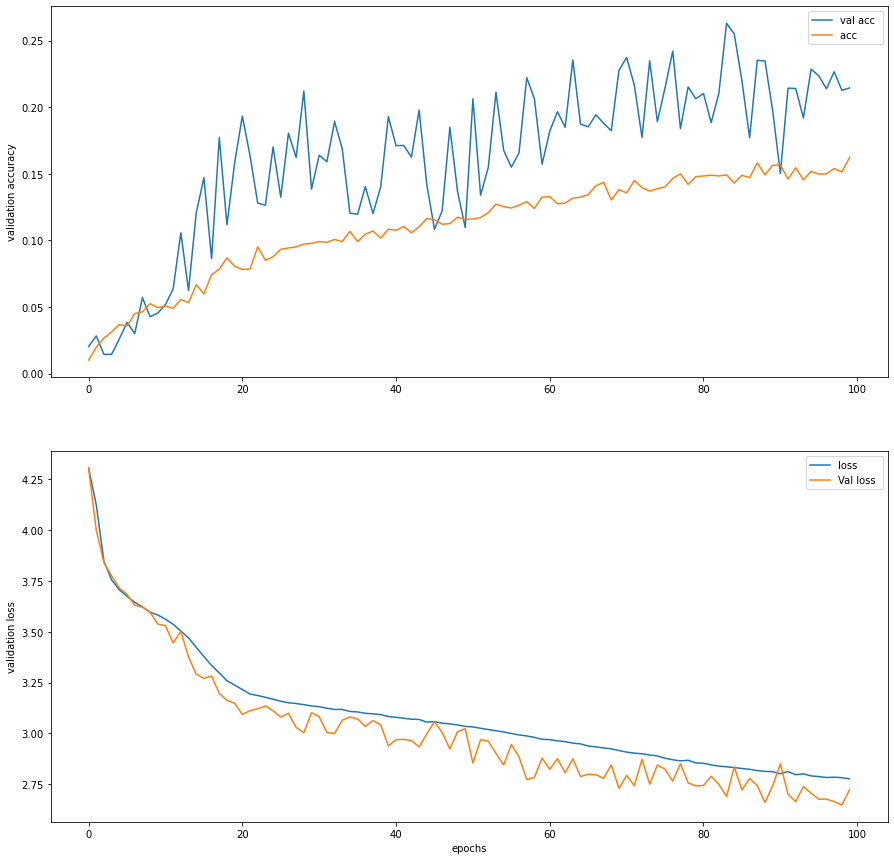

In [28]:
history_dict=history_callback.history
fig, (ax1, ax2) = plt.subplots(2, figsize=(15, 15))

accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

loss = history_dict['loss']
val_loss = history_dict['val_loss']
ax1.plot(val_accuracy, label="val acc ")
ax1.plot(accuracy, label="acc ")

ax2.plot(loss, label= "loss ")
ax2.plot(val_loss, label= "Val loss ")
    
ax1.set_ylabel('validation accuracy')
ax2.set_ylabel('validation loss')
ax2.set_xlabel('epochs')
ax1.legend()
ax2.legend();

--------------------

In [ ]:
### Para guardar los modelos se hace de la siguiente forma
from tensorflow import keras

# Guardar el Modelo
model1.save('my_model1.h5')

# Recrea exactamente el mismo modelo solo desde el archivo
new_model = keras.models.load_model('my_model1.h5')

new_model.summary()

----------------------